# PyTorch Quickstart & Review some basics of ML

Let's follow [QuickStart](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html) first.

## Exercise
### 1. How 'batch' work with each layers?
Let's check out how layers work with batch in pytorch. In this example, shape of a batch is (64, 1, 28, 28) where 64 is batch size. first linear layer takes only $28\times28$ elements in 'Creating Models' part.
```python
class NeuralNetwork(nn.Module):
    def __init__(self):
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.linear(28*28, 512),
            ...
        )
```
#### Flatten() layer
Corresponds to batch, output of Flatten method with default arguments is 2-D array (It does not flatten first dimension). Let's check out output of Flatten layer with different 'start_dim' argument...

In [5]:
class flatten_test(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten0 = nn.Flatten()
        self.flatten1 = nn.Flatten(start_dim=0)
        self.flatten2 = nn.Flatten(start_dim=1)
        
    def flatten_default(self, x):
        x = self.flatten0(x)
        return x
    
    def flatten_sd0(self, x):
        x = self.flatten1(x)
        return x
    
    def flatten_sd1(self, x):
        x = self.flatten2(x)
        return x
    
model_ = flatten_test().to(device)

for X, _ in test_dataloader:
    print(f"Shape of flatten0(X) :{model_.flatten_default(X).shape}")
    print(f"Shape of flatten1(X) :{model_.flatten_sd0(X).shape}")
    print(f"Shape of flatten2(X) :{model_.flatten_sd1(X).shape}")
    break

Shape of flatten0(X) :torch.Size([64, 784])
Shape of flatten1(X) :torch.Size([50176])
Shape of flatten2(X) :torch.Size([64, 784])


Or one can find same information on [Source Code](https://pytorch.org/docs/stable/_modules/torch/nn/modules/flatten.html#Flatten) or help(nn.Flatten).  
Like this, all the layers might assumes one additional dimension for batch. If one disbands, each output of an input does not depend on batch size.

#### Loss and Optimization
How about loss and optimization? Loss should return a continuous number that usually exhibits how prediction was far from label. Optimization updates parameters of model. While it updates model parameters, it cannot just iterate over batch size. 

### 2. How 'loss' and 'optimizer' work with parameters on model?
Loss and Optimizer does not take each other as argument. They take arguments from 'model' only.
```python
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
def train(dataloader, model, loss_fn, optimizer):
    ...
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        ...
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
```

## Reproduce
Just run all the codes on tutorial.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.309076  [   64/60000]
loss: 2.293730  [ 6464/60000]
loss: 2.274800  [12864/60000]
loss: 2.268841  [19264/60000]
loss: 2.264539  [25664/60000]
loss: 2.231301  [32064/60000]
loss: 2.239003  [38464/60000]
loss: 2.209710  [44864/60000]
loss: 2.203876  [51264/60000]
loss: 2.184576  [57664/60000]
Test Error: 
 Accuracy: 42.0%, Avg loss: 2.169872 

Epoch 2
-------------------------------
loss: 2.176080  [   64/60000]
loss: 2.161420  [ 6464/60000]
loss: 2.110287  [12864/60000]
loss: 2.127089  [19264/60000]
loss: 2.088008  [25664/60000]
loss: 2.031430  [32064/60000]
loss: 2.058035  [38464/60000]
loss: 1.986580  [44864/60000]
loss: 1.989994  [51264/60000]
loss: 1.934582  [57664/60000]
Test Error: 
 Accuracy: 57.2%, Avg loss: 1.919530 

Epoch 3
-------------------------------
loss: 1.944512  [   64/60000]
loss: 1.908570  [ 6464/60000]
loss: 1.804672  [12864/60000]
loss: 1.845298  [19264/60000]
loss: 1.744254  [25664/60000]
loss: 1.694258  [32064/600

In [9]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [10]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [11]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


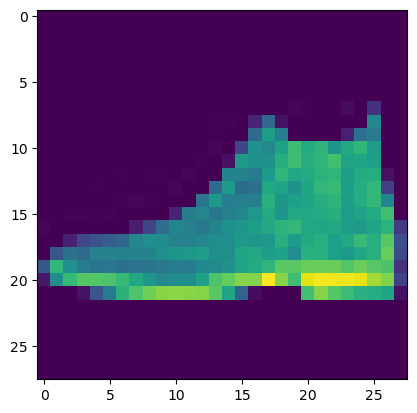

In [13]:
import matplotlib.pyplot as plt
input = test_data[0][0][0]
#plt.imshow(input.to('cpu').numpy())
plt.imshow(input.numpy())
plt.show()

In [14]:
print(test_data[0][0][0].shape)

torch.Size([28, 28])
